In [7]:
using Plots, LinearAlgebra

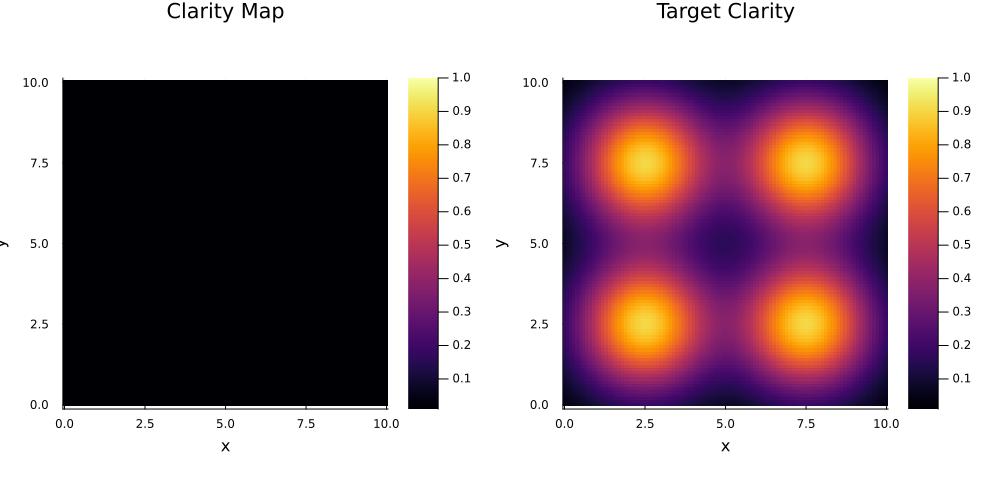

In [8]:
xs = 0:0.1:10;
ys = 0:0.1:10;

dim_x, dim_y = length(xs), length(ys);


# Create a meshgrid
clarity_map = zeros(dim_x, dim_y);

# Create static target clarity map
peaks = [(2.5, 2.5), (2.5, 7.5), (7.5, 2.5), (7.5, 7.5)]
target_clarity = zeros(dim_x, dim_y);
for (px, py) in peaks
    for i in 1:dim_x
        for j in 1:dim_y
            target_clarity[i, j] += 0.9 * exp(-((xs[i] - px)^2 + (ys[j] - py)^2) / 4)
        end
    end
end

claritymapplot = heatmap(xs, ys, clarity_map, aspect_ratio=1, clim=(0.01, 1), xlabel="x", ylabel="y", title="Clarity Map")
targetclarityplot = heatmap(xs, ys, target_clarity, aspect_ratio=1, clim=(0.01, 1), xlabel="x", ylabel="y", title="Target Clarity")
plot(claritymapplot, targetclarityplot, layout=(1, 2), size=(1000, 500))

┌ Info: Saved animation to C:\Users\kavin\AppData\Local\Temp\jl_6B25WDQbQl.gif
└ @ Plots C:\Users\kavin\.julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\kavin\\AppData\\Local\\Temp\\jl_6B25WDQbQl.gif")
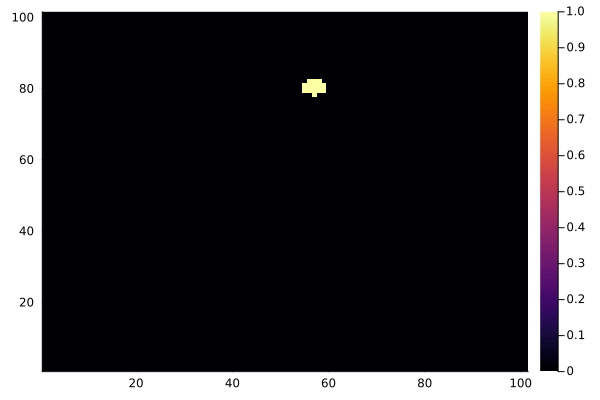

In [9]:
# Define clarity dynamics parameters
Q = 0.01  # Process noise (decay rate)
R = 0.1   # Measurement noise
C = 1.0   # Measurement strength
sensing_radius = 0.25  # Radius of the sensing area

# Robot motion parameters
center = (5.0, 5.0)
radius = 3.0
omega = 0.2  # Angular velocity

# Gaussian function for clarity update
gaussian(x, y, cx, cy, sigma) = exp(-((x - cx)^2 + (y - cy)^2) / (2 * sigma^2))

# Simulate robot movement and clarity update
timesteps = 200
@gif for t in 1:timesteps
    # Compute robot position
    theta = omega * t
    robot_x = center[1] + radius * cos(theta)
    robot_y = center[2] + radius * sin(theta)
    
    # Update clarity within sensing radius
    for m in 1:dim_x, n in 1:dim_y
        distance = sqrt((xs[m] - robot_x)^2 + (ys[n] - robot_y)^2)
        if distance <= sensing_radius
            weight = gaussian(xs[m], ys[n], robot_x, robot_y, sensing_radius / 2)
            clarity_map[m, n] += weight * ((C^2 / R) * (1 - clarity_map[m, n])^2 - Q * clarity_map[m, n]^2)
        else
            clarity_map[m, n] -= Q * clarity_map[m, n]^2
        end
    end
    
    # Ensure clarity values remain within [0,1]
    clarity_map .= clamp.(clarity_map, 0, 1)
    heatmap(clarity_map)
end


┌ Info: Saved animation to C:\Users\kavin\AppData\Local\Temp\jl_EDAZU9Qlot.gif
└ @ Plots C:\Users\kavin\.julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\kavin\\AppData\\Local\\Temp\\jl_EDAZU9Qlot.gif")
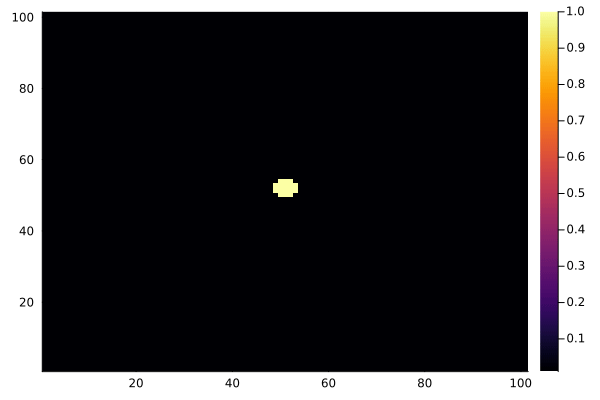

In [15]:
# Function to compute ergodic metric
function ergodic_metric(clarity_map, target_clarity, xs, ys)
    dim_x, dim_y = size(clarity_map)
    metric = 0.0
    for i in 1:dim_x
        for j in 1:dim_y
            metric += (clarity_map[i, j] - target_clarity[i, j])^2
        end
    end
    return metric
end

xs = 0:0.1:10;
ys = 0:0.1:10;

dim_x, dim_y = length(xs), length(ys);


# Create a meshgrid
clarity_map = zeros(dim_x, dim_y);

# Create static target clarity map
peaks = [(2.5, 2.5), (2.5, 7.5), (7.5, 2.5), (7.5, 7.5)]
target_clarity = zeros(dim_x, dim_y);
for (px, py) in peaks
    for i in 1:dim_x
        for j in 1:dim_y
            target_clarity[i, j] += 0.9 * exp(-((xs[i] - px)^2 + (ys[j] - py)^2) / 4)
        end
    end
end

# Initialize robot direction
robot_dir = [1.0, 0.0]  # Initial direction

# Simulation parameters
dt = 0.1  # Time step
speed = 1  # Robot speed

# Simulate robot movement with ergodic control
timesteps = 200
robot_pos = [5.0, 5.0]  # Initial robot position
@gif for t in 1:timesteps    
    global robot_pos
    # Compute ergodic metric for current clarity map
    current_metric = ergodic_metric(clarity_map, target_clarity, xs, ys)
    
    # Compute potential new positions and their metrics
    potential_positions = [
        robot_pos + dt * speed * [cos(theta), sin(theta)] for theta in 0:pi/4:2pi
    ]
    potential_metrics = [
        ergodic_metric(clarity_map, target_clarity, xs, ys) for pos in potential_positions
    ]
    
    # Choose the direction that minimizes the ergodic metric
    min_metric, min_index = findmin(potential_metrics)
    robot_dir = [cos((min_index - 1) * pi/4), sin((min_index - 1) * pi/4)]
    
    # Update robot position
    robot_pos += dt * speed * robot_dir
    
    # Update clarity within sensing radius
    for m in 1:dim_x, n in 1:dim_y
        distance = sqrt((xs[m] - robot_pos[1])^2 + (ys[n] - robot_pos[2])^2)
        if distance <= sensing_radius
            weight = gaussian(xs[m], ys[n], robot_pos[1], robot_pos[2], sensing_radius / 2)
            clarity_map[m, n] += weight * ((C^2 / R) * (1 - clarity_map[m, n])^2 - Q * clarity_map[m, n]^2)
        else
            clarity_map[m, n] -= Q * clarity_map[m, n]^2
        end
    end
    
    # Ensure clarity values remain within [0,1]
    clarity_map .= clamp.(clarity_map, 0, 1)
    heatmap(clarity_map, clim=(0.01, 1))
end